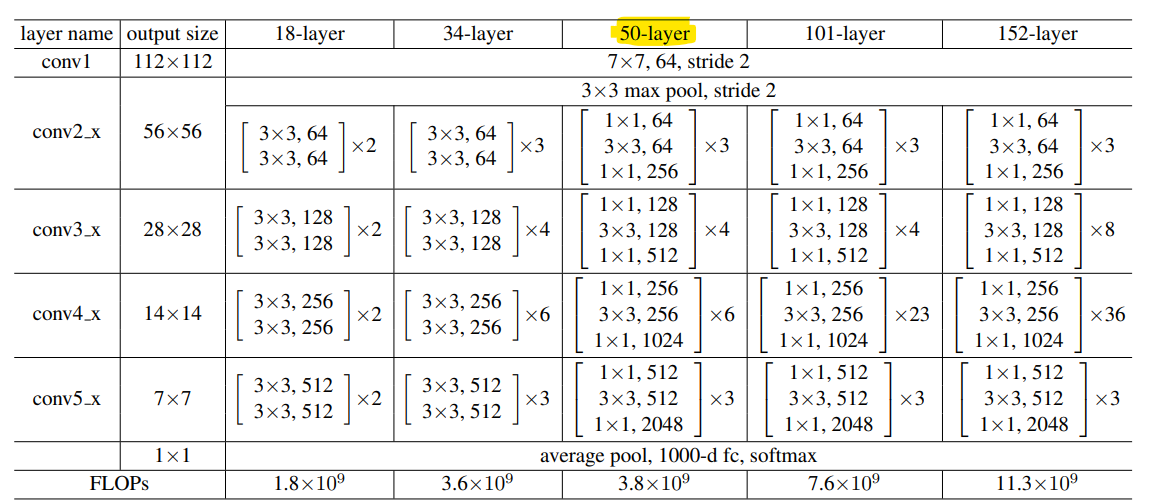

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Bottleneck(nn.Module):
    expansion = 4  # 확장 비율, Bottleneck 구조에서 마지막 Conv Layer의 출력 채널이 입력 채널의 4배가 됨

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        # 첫 번째 1x1 Convolution
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # 두 번째 3x3 Convolution, stride는 주어진 값 사용
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # 세 번째 1x1 Convolution, 채널 확장
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample  # 입력의 형상을 출력의 형상에 맞춰주기 위한 downsampling layer

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=100):
        super(ResNet, self).__init__()
        self.in_channels = 64
        # 초기 Convolution과 Max Pooling Layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # Residual Blocks
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # 평균 풀링과 Fully Connected Layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        # 입력 데이터의 형상을 확인하기 위한 출력
        print("Input Shape:", x.shape)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # 각 Residual Block을 통과한 후의 형상 출력
        x = self.layer1(x)
        print("After Layer 1 Shape:", x.shape)
        x = self.layer2(x)
        print("After Layer 2 Shape:", x.shape)
        x = self.layer3(x)
        print("After Layer 3 Shape:", x.shape)
        x = self.layer4(x)
        print("After Layer 4 Shape:", x.shape)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [2]:
def resnet50():
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=100)

def resnet101():
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=100)

def resnet152():
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes=100)

In [3]:
# 모델 생성
model = resnet50()

# 샘플 데이터 생성 및 모델을 통과시켜 형상 확인
sample_input = torch.rand(1, 3, 224, 224) # 배치 크기 1, 채널 3, 높이와 너비가 224인 임의의 이미지 텐서
output = model(sample_input)

Input Shape: torch.Size([1, 3, 224, 224])
After Layer 1 Shape: torch.Size([1, 256, 56, 56])
After Layer 2 Shape: torch.Size([1, 512, 28, 28])
After Layer 3 Shape: torch.Size([1, 1024, 14, 14])
After Layer 4 Shape: torch.Size([1, 2048, 7, 7])


In [4]:
from torchsummary import summary

summary(model.cuda(), (3,224,224))

Input Shape: torch.Size([2, 3, 224, 224])
After Layer 1 Shape: torch.Size([2, 256, 56, 56])
After Layer 2 Shape: torch.Size([2, 512, 28, 28])
After Layer 3 Shape: torch.Size([2, 1024, 14, 14])
After Layer 4 Shape: torch.Size([2, 2048, 7, 7])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]      